# Example
Designing a 24 hours ahead water inflow forecast.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Callable
from IPython.display import display
from ipywidgets import SelectMultiple, interact, IntProgress, IntSlider

from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from darts import TimeSeries
from darts.models import XGBModel

from testing_functions import compute_errors, get_rmse, get_mape

## Modelling

Total number of train samples 6961


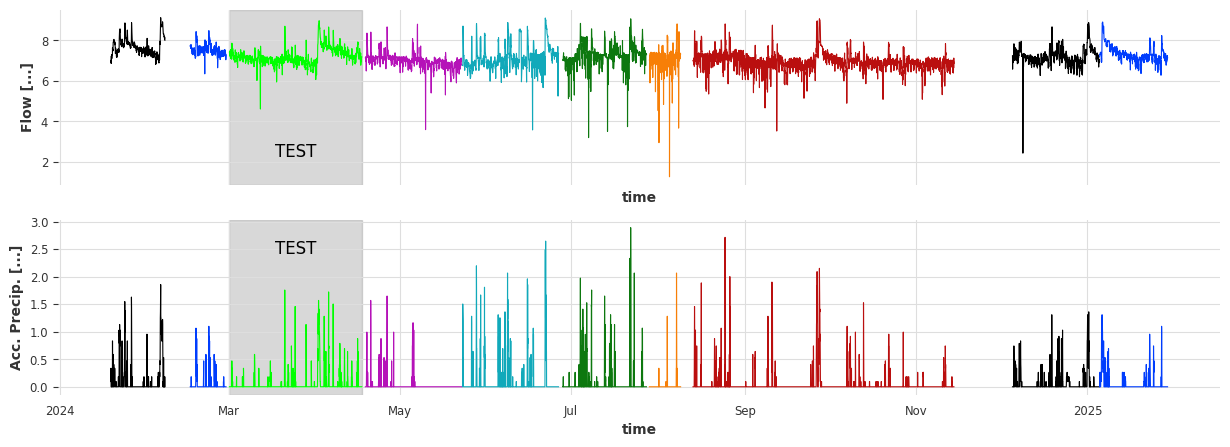

In [2]:
%run baseline.ipynb

n_subseries: int = n_subseries  # type: ignore # noqa: F821
n_features: int = n_features  # type: ignore # noqa: F821

output_chunk_length: int = output_chunk_length  # type: ignore # noqa: F821

target_subseries: List[TimeSeries] = target_subseries  # type: ignore # noqa: F821
expanded_covariates: List[TimeSeries] = expanded_covariates  # type: ignore # noqa: F821

test_target: TimeSeries = test_target  # type: ignore # noqa: F821
test_covariates: TimeSeries = test_covariates  # type: ignore # noqa: F821

df_baseline: pd.DataFrame = df_baseline  # type: ignore # noqa: F821
assemble_comparison: Callable = assemble_comparison  # type: ignore # noqa: F821

In [ ]:
def is_future(target: str) -> bool:
    future_tags = ["polyfeature_", "dow_", "hour_"]
    return any(sub in target for sub in future_tags)


all_past_components = [c for c in expanded_covariates[0].components if not is_future(c)]
all_future_components = [c for c in expanded_covariates[0].components if is_future(c)]

In [ ]:
n_ar_lags = 6
n_past_lags = 6
n_future_lags = (6, output_chunk_length)
n_lags = max(n_ar_lags, n_past_lags, n_future_lags[1])

encoders = {"cyclic": {"future": "month"}}

xgbmodel = XGBModel(
    lags=n_ar_lags,
    lags_past_covariates=n_past_lags,
    lags_future_covariates=n_future_lags,
    output_chunk_length=output_chunk_length,
    add_encoders=encoders,
)

We define the `Model` class to better access the model and its estimator (will be used during feature selection).

In [ ]:
class Model:
    def __init__(self, model: XGBModel):
        self.model = model
        self.estimator = model.get_estimator(0, 0)


candidate = Model(xgbmodel)

Model supports multi-output; a single estimator forecasts all the horizons and components.


#### Feature selection
- In order to select features I run RFECV on every subseries. I will select the features that were selected in more than half of the subseries.

In [16]:
pbar = IntProgress(min=0, max=n_subseries)
display(pbar)

used_features = np.zeros(n_features)
original_components = list(expanded_covariates[0].components)

for target_i, covariates_i in zip(target_subseries, expanded_covariates):
    # Here, the estimator is not taking the past into account
    selector = RFECV(
        candidate.estimator,
        step=0.05,
        min_features_to_select=5,
        cv=TimeSeriesSplit(n_splits=4),
    )

    # The selection is made taking into account only the next time step
    selector = selector.fit(covariates_i.values(), target_i.values())
    used_features += selector.support_.astype(int)
    pbar.value += 1

# We only select features that have been selected in at least half of the subseries
index_relevant_features = [
    int(i) for i in np.where(used_features / n_subseries >= 0.5)[0]
]

selected_components = [original_components[i] for i in index_relevant_features]

IntProgress(value=0, max=9)

In [17]:
past_components = [fn for fn in selected_components if fn in all_past_components]
future_components = [fn for fn in selected_components if fn in all_future_components]

assert len(past_components) > 0
assert len(future_components) > 0

selected_past_covariates = [s[past_components] for s in expanded_covariates]
selected_past_covariates_test = test_covariates[past_components]

selected_future_covariates = [s[future_components] for s in expanded_covariates]
selected_future_covariates_test = test_covariates[future_components]

In [10]:
candidate.model.fit(
    target_subseries,
    future_covariates=selected_future_covariates,
    past_covariates=selected_past_covariates,
)

XGBModel(lags=6, lags_past_covariates=6, lags_future_covariates=(6, 12), output_chunk_length=12, output_chunk_shift=0, add_encoders={'cyclic': {'future': 'month'}}, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [18]:
print(len(selected_components), candidate.estimator.n_features_in_)

18 318


Despite the number of selected features is relatively small, once we include their lags, the number of features greatly increases.

## Testing

In [12]:
feature_i = SelectMultiple(
    options=past_components,
    value=past_components[:1],
    description="Features to compare",
)

nudger = IntSlider(min=-12, max=12, value=0, description="Nudge pred. start")


@interact(features=feature_i, nudge=nudger)
def plot_forecast(features, nudge):
    arbitrary_breakpoints = [400, 650, 750, 810, 968]  # Needs to be above n_lags
    fig, axes = plt.subplots(
        2, len(arbitrary_breakpoints), figsize=(20, 5), sharey="row", sharex="col"
    )
    for i, n_split in enumerate(arbitrary_breakpoints):
        time_axis = test_target.slice(
            test_target.time_index[n_split - n_lags],
            test_target.time_index[n_split + output_chunk_length],
        ).time_index
        minx = time_axis.min()
        maxx = time_axis.max()

        test_in, test_out = test_target.split_before(n_split + nudge)

        predicted_inflow = candidate.model.predict(
            series=test_in,
            n=output_chunk_length,
            past_covariates=selected_past_covariates_test,
            future_covariates=selected_future_covariates_test,
        )

        actual_inflow = test_target.slice(start_ts=minx, end_ts=maxx)

        predicted_inflow.plot(label="predicted", ax=axes[0, i])
        actual_inflow.plot(label="actual", ax=axes[0, i])

        selected_past_covariates_test[list(features)].slice_intersect(
            actual_inflow
        ).plot(ax=axes[1, i])

        axes[0, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")
        axes[1, i].axvline(x=test_out.time_index[0], c="red", linestyle="dashed")

        axes[0, i].set_xlim(minx, maxx)
        axes[1, i].set_xlim(minx, maxx)

    plt.tight_layout()


interactive(children=(SelectMultiple(description='Features to compare', index=(0,), options=('mean_pressure', …

- At every step of the test series, we forecast the next 12 hours and compare.

In [13]:
candidate_errors = compute_errors(
    test_target,
    candidate.model,
    output_chunk_length,
    past_covariates=selected_past_covariates_test,
    future_covariates=selected_future_covariates_test,
    output_transform=np.expm1,
)

In [14]:
df_candidate = pd.DataFrame(
    {
        "RMSE": get_rmse(candidate_errors),
        "MAPE": get_mape(candidate_errors),
        "model": "xgb2",
    }
)

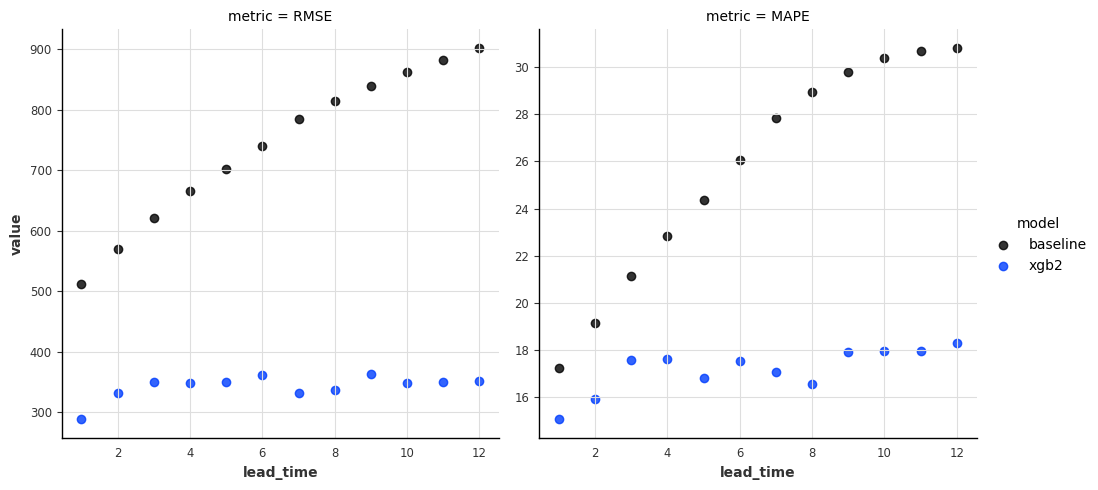

In [15]:
comparison = assemble_comparison([df_baseline, df_candidate])

sns.lmplot(
    data=comparison,
    x="lead_time",
    y="value",
    col="metric",
    hue="model",
    fit_reg=False,
    facet_kws=dict(sharey=False),
)